In [7]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset, Subset, DataLoader, random_split
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt

In [9]:
# Set your dataset path
dataset_path = r"C:\Users\harta\Desktop\mudra_dataset"  # Replace YourName with your actual username

# Define transformations
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Load full dataset
full_dataset = datasets.ImageFolder(root=dataset_path, transform=train_transform)
print(f"Full dataset: {len(full_dataset)} images, {len(full_dataset.classes)} classes")

# Create balanced subset with max 100 images per class
def create_balanced_subset(dataset, max_samples_per_class=100):
    """Create a balanced subset with limited samples per class"""
    class_indices = {}
    
    # Group indices by class
    for idx, (_, label) in enumerate(dataset.samples):
        if label not in class_indices:
            class_indices[label] = []
        class_indices[label].append(idx)
    
    # Select limited samples per class
    selected_indices = []
    for label, indices in class_indices.items():
        if len(indices) > max_samples_per_class:
            # Randomly select max_samples_per_class indices
            selected_indices.extend(np.random.choice(indices, max_samples_per_class, replace=False))
        else:
            # Use all available indices
            selected_indices.extend(indices)
    
    return Subset(dataset, selected_indices)

# Create balanced subsets
max_samples = 100  # Maximum images per class
train_dataset_full = datasets.ImageFolder(root=dataset_path, transform=train_transform)
train_subset = create_balanced_subset(train_dataset_full, max_samples)

test_dataset_full = datasets.ImageFolder(root=dataset_path, transform=val_transform) 
test_subset = create_balanced_subset(test_dataset_full, max_samples)

# Split the subset into train and test
combined_indices = list(range(len(train_subset)))
np.random.shuffle(combined_indices)

train_size = int(0.8 * len(combined_indices))
test_size = len(combined_indices) - train_size

train_indices = combined_indices[:train_size]
test_indices = combined_indices[train_size:]

train_dataset = Subset(train_subset.dataset, [train_subset.indices[i] for i in train_indices])
test_dataset = Subset(test_subset.dataset, [test_subset.indices[i] for i in test_indices])

print(f"Balanced subset: {len(train_subset)} total images")
print(f"Training images: {len(train_dataset)}")
print(f"Test images: {len(test_dataset)}")
print(f"Number of classes: {len(full_dataset.classes)}")

Full dataset: 9670 images, 50 classes
Balanced subset: 4932 total images
Training images: 3945
Test images: 987
Number of classes: 50


In [11]:
# Create DataLoaders with smaller batch size for faster training
batch_size = 16  # Reduced from 32 for faster training
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Test one batch
for images, labels in train_dataloader:
    print(f"Batch images shape: {images.shape}")  # Should be [16, 3, 224, 224]
    print(f"Batch labels shape: {labels.shape}")  # Should be [16]
    print(f"Sample labels: {labels[:5]}")
    break

Batch images shape: torch.Size([16, 3, 224, 224])
Batch labels shape: torch.Size([16])
Sample labels: tensor([11, 18, 29, 39, 43])


In [13]:
from torchvision import models
import torch.nn as nn

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Use a smaller model for faster training
model = models.resnet18(pretrained=True)  # ResNet18 instead of ResNet50

# Replace the final layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(full_dataset.classes))
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)  # Faster learning rate decay

print(f"Model setup for {len(full_dataset.classes)} classes")
print("Using ResNet18 for faster training")

Using device: cpu


C:\Users\harta\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\harta\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\harta/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|█████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:19<00:00, 2.46MB/s]


Model setup for 50 classes
Using ResNet18 for faster training


In [15]:
num_epochs = 8  # Reduced from 15 for faster training
train_losses = []
val_accuracies = []

print("Starting fast training with balanced subset...")
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    
    for batch_idx, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # Print progress every 20 batches
        if batch_idx % 20 == 0:
            print(f"Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.4f}")

    avg_train_loss = running_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    val_accuracies.append(accuracy)

    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Test Accuracy: {accuracy:.2f}%")

print('Fast training completed!')

Starting fast training with balanced subset...
Epoch 1, Batch 0, Loss: 3.9565
Epoch 1, Batch 20, Loss: 3.3114
Epoch 1, Batch 40, Loss: 1.8960
Epoch 1, Batch 60, Loss: 1.7371
Epoch 1, Batch 80, Loss: 1.8553
Epoch 1, Batch 100, Loss: 1.0713
Epoch 1, Batch 120, Loss: 1.4167
Epoch 1, Batch 140, Loss: 1.3502
Epoch 1, Batch 160, Loss: 0.8192
Epoch 1, Batch 180, Loss: 0.9228
Epoch 1, Batch 200, Loss: 0.6842
Epoch 1, Batch 220, Loss: 0.9219
Epoch 1, Batch 240, Loss: 0.7570
Epoch [1/8], Train Loss: 1.5728, Test Accuracy: 68.59%
Epoch 2, Batch 0, Loss: 0.6057
Epoch 2, Batch 20, Loss: 1.1536
Epoch 2, Batch 40, Loss: 0.6600
Epoch 2, Batch 60, Loss: 0.6255
Epoch 2, Batch 80, Loss: 1.5663
Epoch 2, Batch 100, Loss: 0.5905
Epoch 2, Batch 120, Loss: 0.5319
Epoch 2, Batch 140, Loss: 0.5826
Epoch 2, Batch 160, Loss: 0.4021
Epoch 2, Batch 180, Loss: 0.7799
Epoch 2, Batch 200, Loss: 0.4436
Epoch 2, Batch 220, Loss: 0.6693
Epoch 2, Batch 240, Loss: 1.4037
Epoch [2/8], Train Loss: 0.6758, Test Accuracy: 73.9

In [7]:
import torch
from torchvision import models, transforms, datasets
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from PIL import Image

# Load the saved checkpoint
checkpoint = torch.load('fast_mudra_classifier.pth', map_location=torch.device('cpu'))

# Extract information
class_to_idx = checkpoint['class_to_idx']
idx_to_class = checkpoint['idx_to_class']
train_losses = checkpoint['train_losses']
val_accuracies = checkpoint['val_accuracies']

print("Model checkpoint loaded successfully!")
print(f"Training had {len(train_losses)} epochs")
print(f"Best validation accuracy: {max(val_accuracies):.2f}%")

Model checkpoint loaded successfully!
Training had 8 epochs
Best validation accuracy: 98.48%


In [9]:
# Initialize model architecture
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_to_idx))

# Load trained weights
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set to evaluation mode

print("Model loaded successfully!")
print(f"Model architecture: {checkpoint['model_architecture']}")
print(f"Number of classes: {checkpoint['num_classes']}")

C:\Users\harta\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\harta\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded successfully!
Model architecture: resnet18
Number of classes: 50


In [11]:
# Define transformations (same as during training)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Reload test dataset
dataset_path = r"C:\Users\harta\Desktop\mudra_dataset"
test_dataset_full = datasets.ImageFolder(root=dataset_path, transform=val_transform)

# We need to recreate the test subset exactly as during training
# Since we can't exactly reproduce the random split, let's use a simple approach
# Alternatively, you can load the full test set for evaluation

# For now, let's use a smaller test set for evaluation
test_subset = torch.utils.data.Subset(test_dataset_full, range(500))  # Use first 500 images
test_dataloader = torch.utils.data.DataLoader(test_subset, batch_size=16, shuffle=False)

print(f"Test dataloader created with {len(test_subset)} images")

Test dataloader created with 500 images


🎯 Final Test Accuracy: 96.80%


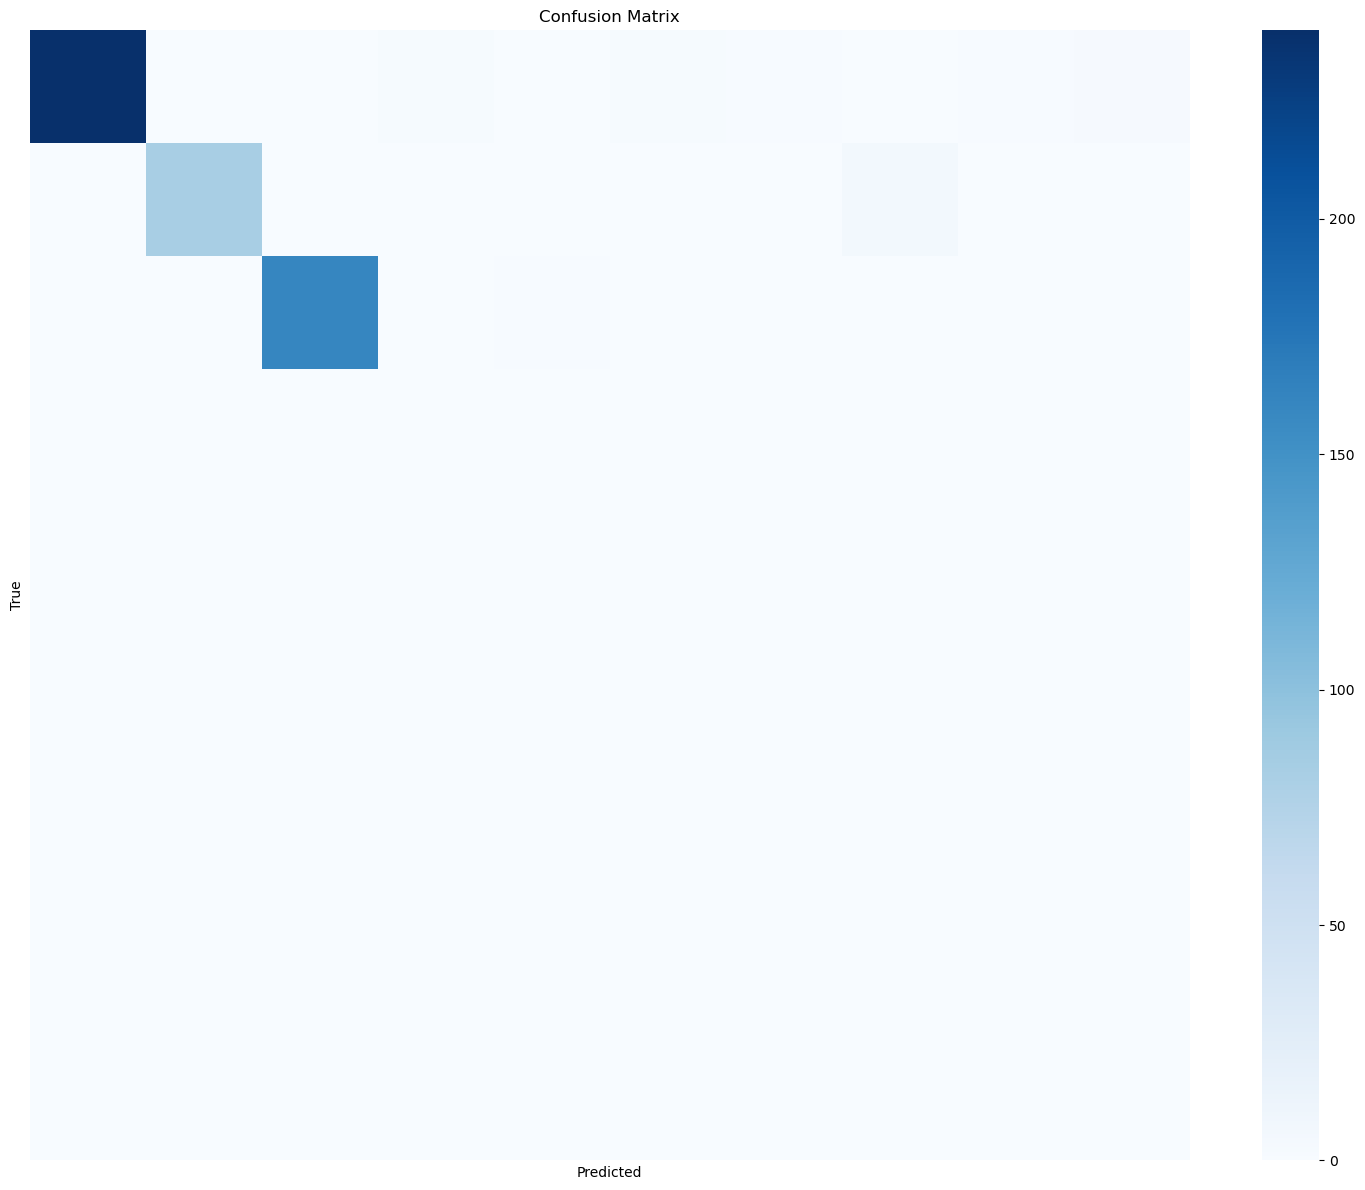


📊 Classification Report:


ValueError: Number of classes, 10, does not match size of target_names, 50. Try specifying the labels parameter

In [13]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Run evaluation
model.eval()
all_predictions = []
all_true_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        all_predictions.extend(predicted.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

# Final accuracy
final_accuracy = 100 * np.mean(np.array(all_predictions) == np.array(all_true_labels))
print(f"🎯 Final Test Accuracy: {final_accuracy:.2f}%")

# Confusion matrix
plt.figure(figsize=(15, 12))
cm = confusion_matrix(all_true_labels, all_predictions)
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=False, yticklabels=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Classification report
print("\n📊 Classification Report:")
print(classification_report(all_true_labels, all_predictions, 
                           target_names=[idx_to_class[i] for i in range(len(idx_to_class))],
                           zero_division=0, digits=4))

In [17]:
def predict_mudra(image_path, model, transform, idx_to_class, device='cpu'):
    """Predict mudra from an image file - simple version"""
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.softmax(output, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
    
    predicted_class = idx_to_class[predicted.item()]
    confidence_score = confidence.item()
    
    return {
        'predicted_class': predicted_class,
        'confidence': confidence_score,
        'all_probabilities': probabilities.cpu().numpy()[0]
    }

In [65]:
# Get the full path to your desktop image
# Replace 'your_photo.jpg' with your actual filename
image_path = r"C:\Users\harta\Desktop\finger-Photoroom.png"

# Test the prediction
prediction = predict_mudra(image_path, model, val_transform, idx_to_class, device)
print("Prediction Results:")
print(f"Predicted class: {prediction['predicted_class']}")
print(f"Confidence: {prediction['confidence']:.2%}")

Prediction Results:
Predicted class: Suchi(1)
Confidence: 55.21%


In [33]:
# Save the trained model
checkpoint = {
    'model_state_dict': model.state_dict(),
    'class_to_idx': class_to_idx,
    'idx_to_class': {v: k for k, v in class_to_idx.items()},
    'train_losses': train_losses,
    'val_accuracies': val_accuracies,
    'model_architecture': 'resnet18',
    'num_classes': 50
}

torch.save(checkpoint, 'fast_mudra_classifier.pth')
print("Model saved as 'fast_mudra_classifier.pth'")

Model saved as 'fast_mudra_classifier.pth'
